# Reconocedor de razas de perro

Desarrollo de una **red neuronal convolucional** que reconoce distintas razas de perro usando fotografías de los mismos.

#### Las distintas razas que la red va a identificar y clasificar son:

* Corgi
* Husky
* Pug
* Dachshund (Perro salchicha)

La red neuronal deberá aprender a reconocer una diversidad de objetos (en este caso perros) dentro de imágenes y para ello necesitaremos una gran cantidad de imágenes para que la red pueda captar las características únicas de cada objeto y a su vez, poder generalizarlo.

Puedes encontrar el dataset que utilizaré en el siguiente [enlace](https://www.kaggle.com/ashishvns/dogclassification).

#### Nos conectamos a Google Drive:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Comprobamos que el dataset con el que vamos a trabajar se ha cargado correctamente:

temp  test  train


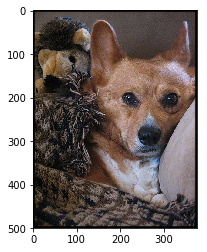

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/dogs"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/dogs/train/corgi/corgi (14).jpg', 'r')
imshow(np.asarray(pil_im))

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Primer modelo

**Descripción del modelo:**

* Importaremos las librerías necesarias.
* Normalizaremos las imágenes y los datos.
* Implementaremos el modelo.
* Realizaremos el entrenamiento.
* Compararemos resultados.

#### Importamos de la API Keras:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time
import numpy as np
import matplotlib.pyplot as plt

#### Fuente de los datos:

* Conviene que todas las imágenes tengan el mismo tamaño, para ello las reescalamos a **100x100 px**.

* Contaremos con los **datos de entrenamiento** y los **datos de validación**.

* La red toma como entrada los pixeles de una imagen. Antes de alimentar la red, como entrada conviene **normalizar los valores**: 
  * Los colores de los pixeles tienen valores que van de 0 a 255, haremos una transformación de cada pixel: valor/255 y nos quedará siempre un valor entre **0 y 1**.

In [0]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/dogs/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/dogs/test'

# ImageDataGenerator - Método para el procesamiento de imágenes

# Generación de los datos de entrenamiento y los de validación

train_datagen = ImageDataGenerator( 
        rescale=1./255,             # Normalización de valores entre 0 y 1
        shear_range=0.2,            # Ángulo para girar la imagen
        zoom_range=0.2,             # Zoom a la imagen
        horizontal_flip=True)       # Obtenemos el doble de imágenes al voltearlas horizontalmente

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100, 100),      # 100x100 -  dimensiones a las que se redimensionarán todas las imágenes
        batch_size=128,              # Número de muestras que se cogen en cada paso del entrenamiento
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical')

Found 3243 images belonging to 4 classes.
Found 817 images belonging to 4 classes.


#### El modelo y su estructura:

* El modelo está compuesto por **varias capas convolucionales**. 
   * Las **convoluciones** consisten en tomar «grupos de pixeles cercanos» de la imagen de entrada e ir operando matemáticamente (producto escalar) contra una pequeña matriz que se llama kernel. El conjunto de kernel se llama filtros.
   * La primera convolución es capaz de detectar características primitivas como lineas ó curvas. A medida que hagamos más capas con las convoluciones, los mapas de características serán capaces de reconocer formas más complejas, y el conjunto total de capas de convoluciones podrá «ver».
* Con la técnica de **MaxPooling** iniciamos un proceso de subsampling en el que reduciremos el tamaño de nuestras imágenes filtradas pero en donde deberán prevalecer las características más importantes que detectó cada filtro. 
* Para **evitar el overfitting**, añadimos una técnica llamada **Dropout**. 
* Finalmente, usaremos una capa aplanada (**Flatten**) y algunas capas de neuronas "tradicionales" **Fully Connected**.

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),     # 32 filtros con tamaño de kernel de 3x3
                 activation='relu',          # Función de activación
                 input_shape=(100, 100, 3))) # Tamaño de la imagen entrante 
model.add(MaxPooling2D(pool_size=(2, 2)))    # Se reducen la cantidad de neuronas

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 10, 128)       0         
__________

#### Entrenamiento:

In [0]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=10, 
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//32,
)

Epoch 1/10
200/200 [==============================] - 227s 1s/step - loss: 1.2101 - acc: 0.4885 - val_loss: 1.0088 - val_acc: 0.5885
Epoch 2/10
200/200 [==============================] - 223s 1s/step - loss: 0.9198 - acc: 0.6274 - val_loss: 0.9115 - val_acc: 0.6178
Epoch 3/10
200/200 [==============================] - 225s 1s/step - loss: 0.7374 - acc: 0.7138 - val_loss: 0.8450 - val_acc: 0.6573
Epoch 4/10
200/200 [==============================] - 225s 1s/step - loss: 0.5821 - acc: 0.7760 - val_loss: 0.8007 - val_acc: 0.7108
Epoch 5/10
200/200 [==============================] - 225s 1s/step - loss: 0.4629 - acc: 0.8272 - val_loss: 0.9044 - val_acc: 0.6892
Epoch 6/10
200/200 [==============================] - 227s 1s/step - loss: 0.3683 - acc: 0.8636 - val_loss: 1.1361 - val_acc: 0.6497
Epoch 7/10
200/200 [==============================] - 227s 1s/step - loss: 0.2970 - acc: 0.8936 - val_loss: 1.0211 - val_acc: 0.6968
Epoch 8/10
200/200 [==============================] - 229s 1s/step - 

#### En los siguientes gráficos podemos observar de una manera más sencilla el comportamiento de nuestra red:

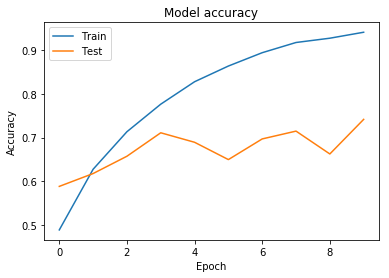

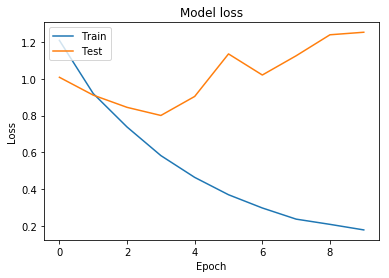

In [0]:
# Gráfico de precisión de los valores de validación y entrenamiento

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Gráfico de error de los valores de validación y entrenamiento

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Podemos guardar nuestro modelo de la siguiente forma:


In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/models/dogs.h5')

#### Realizamos algunas pruebas para observar el comportamiento del modelo:

Para ello hacemos uso de model predict.

In [0]:
valFinal = ['Corgi', 'Husky', 'Pug', 'Dachshund']  # Valores que me van a dar luego
valReal = [1,2,3,4]  # Lo que tiene que corresponder
entradas = np.empty((4,100,100,3))  # Array vacío con esas dimensiones para las entradas

#Entradas

entradas[0] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/dogs/train/corgi/corgi (12).jpg')).resize((100,100))).reshape(1,100,100,3)/255)
entradas[1] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/dogs/train/husky/husky (608).jpg')).resize((100,100))).reshape(1,100,100,3)/255)
entradas[2] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/dogs/train/pug/pug (615).jpg')).resize((100,100))).reshape(1,100,100,3)/255)
entradas[3] = (np.array((Image.open('/content/drive/My Drive/Colab Notebooks/datasets/dogs/train/dachshund/dachshund (274).jpg')).resize((100,100))).reshape(1,100,100,3)/255)

predictions = model.predict(entradas)  # Conforme a las entradas que le pasamos nos genera unas predicciones, y las guardamos
for p,v in zip(predictions, valReal):  # Recorremos las predicciones comparando con lo que nos tendría que dar 
  resultado = np.where(p == np.amax(p))[0]  # Cogemos el índice mayor porque será el que ha sido más preciso
  print("Prediction: ", valFinal[int(resultado)], " ||| ", "Real Value: ", valFinal[v-1])  # Valores

Prediction:  Corgi  |||  Real Value:  Corgi
Prediction:  Pug  |||  Real Value:  Pug
Prediction:  Dachshund  |||  Real Value:  Dachshund
Prediction:  Husky  |||  Real Value:  Husky


## Segundo modelo (Keras VGG-16):

**VGG16 es un modelo de red neuronal convolucional** propuesto por K. Simonyan y A. Zisserman de la Universidad de Oxford en el documento “Very Deep Convolutional Networks for Large-Scale Image Recognition”. 
El modelo alcanza el **92.7% de precisión** de las 5 mejores pruebas en ImageNet, que es un conjunto de datos de más de **14 millones de imágenes** pertenecientes a **1000 clases**.

**Descripción del modelo:**

* Importaremos las librerías necesarias.
* Normalizaremos las imágenes y los datos.
* Implementaremos el modelo VGG-16 ya proporcionado.
* Realizaremos el entrenamiento.
* Compararemos resultados.

#### Realizamos las importaciones necesarias como en el modelo anterior:

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from keras import backend as K
import keras
from time import time

#### Fuente de los datos:

* Al igual que en el modelo anterior, conviene que todas las imágenes tengan el mismo tamaño, para ello las reescalamos a **100x100 px**.

* Además, aquí también contaremos con los **datos de entrenamiento** y los **datos de validación**.

* La red toma como entrada los pixeles de una imagen. Antes de alimentar la red, como entrada conviene **normalizar los valores**: 
  * Los colores de los pixeles tienen valores que van de 0 a 255, haremos una transformación de cada pixel: valor/255 y nos quedará siempre un valor entre **0 y 1**.

In [0]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/dogs/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/datasets/dogs/test'

train_datagen = ImageDataGenerator(
        rescale=1./255)

validation_datagen = ImageDataGenerator(        
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100, 100),
        batch_size=128,
        shuffle = False,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100, 100),
        batch_size=32,
        shuffle = False,
        class_mode='categorical')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n // validation_generator.batch_size

Found 3243 images belonging to 4 classes.
Found 817 images belonging to 4 classes.


####Vamos a hacer uso de una técnica que nos va a ahorrar mucho tiempo:
Esta técnica consiste en pasar todas las imagenes una vez por el modelo VGG-16 y guardar las salidas en un vector (bottleneck). Esa salida es la que se tomará como entrada para las capas siguientes que nosotros implementaremos. Esto es así porque el resultado de pasar una imagen varias veces por las capas convolucionales es estático. Extraemos las características principales de las imagenes con las capas convolucionales y las clasificamos con las Fully-Connected.

![bottleneck_features_example](https://miro.medium.com/max/2000/1*9E3X0hEovE6MnkoDloZalw.png)

In [0]:
import numpy as np
from keras import applications
from sklearn.preprocessing import LabelBinarizer

# Definimos el modelo. Tan fácil como llamar al existente en Keras con los pesos del imagenet:

conv_model = applications.VGG16(include_top=False, weights='imagenet')

encoder = LabelBinarizer() # one-hot 

# Generamos los resultados de la red convolucional

# Se genera un vector con los resultados del paso de las imagenes por las capas convolucionales
# Este vector será la entrada de las capas fully connected, de esta manera, ahorraremos una gran 
# cantidad de tiempo

# Training samples ------------------

bottleneck_features_train = conv_model.predict_generator(
    train_generator,
    steps=STEP_SIZE_TRAIN)

np.save(open('bottleneck_features_train.npy', 'wb'),
        bottleneck_features_train)

np.save(open('bottleneck_labels_train.npy', 'wb'),
        encoder.fit_transform(train_generator.classes))

# Validation samples ------------------

bottleneck_features_validation = conv_model.predict_generator(
    validation_generator,
    steps=STEP_SIZE_VALIDATION)

np.save(open('bottleneck_features_validation.npy', 'wb'),
        bottleneck_features_validation)

np.save(open('bottleneck_labels_validation.npy', 'wb'),
        encoder.fit_transform(validation_generator.classes))

# Vectores

print("Train feature maps shape:", bottleneck_features_train.shape)
print("Validation feature maps shape:", bottleneck_features_validation.shape)

Train feature maps shape: (3200, 3, 3, 512)
Validation feature maps shape: (800, 3, 3, 512)


In [0]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.load(open('bottleneck_labels_train.npy', 'rb'))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.load(open('bottleneck_labels_validation.npy', 'rb'))

#### Nuestra contribución al modelo:

Después de que las imágenes han pasado por las capas convolucionales, ahora le agregamos las siguientes capas que implementamos en el modelo anterior, claramente eliminando las convolucionales, ya que ese paso ya está hecho.

In [0]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               589952    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 516       
Total params: 590,468
Trainable params: 590,468
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento:

In [0]:
history = model.fit(train_data, train_labels[:3200],
          epochs=20,
          batch_size=32,
          shuffle=True,
          validation_data=(validation_data, validation_labels[:800]))

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 2s 506us/step - loss: 1.1885 - acc: 0.4891 - val_loss: 1.1619 - val_acc: 0.5238
Epoch 2/20
3200/3200 [==============================] - 1s 202us/step - loss: 0.9226 - acc: 0.6197 - val_loss: 0.9408 - val_acc: 0.6075
Epoch 3/20
3200/3200 [==============================] - 1s 200us/step - loss: 0.7907 - acc: 0.6834 - val_loss: 0.9049 - val_acc: 0.6338
Epoch 4/20
3200/3200 [==============================] - 1s 204us/step - loss: 0.7174 - acc: 0.7125 - val_loss: 0.8909 - val_acc: 0.6350
Epoch 5/20
3200/3200 [==============================] - 1s 204us/step - loss: 0.6302 - acc: 0.7438 - val_loss: 0.8235 - val_acc: 0.6863
Epoch 6/20
3200/3200 [==============================] - 1s 205us/step - loss: 0.6092 - acc: 0.7606 - val_loss: 1.0069 - val_acc: 0.6112
Epoch 7/20
3200/3200 [==============================] - 1s 206us/step - loss: 0.5248 - acc: 0.8050 - val_loss: 0.8756 - val_acc: 0.6412
E

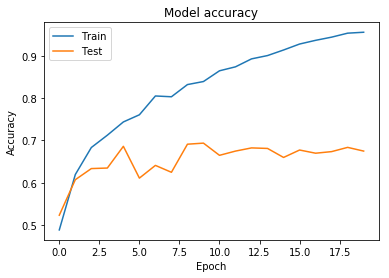

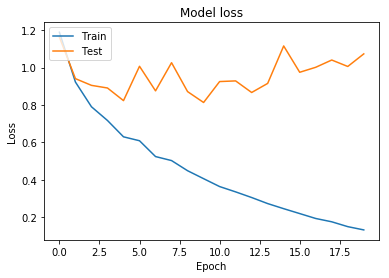

In [0]:
# Gráfico de precisión de los valores de validación y entrenamiento

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Gráfico de error de los valores de validación y entrenamiento

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()